In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
# Load the Dataset

go_emotions = load_dataset("go_emotions")

print(f"Train: {len(go_emotions['train']):,}")
print(f"Val: {len(go_emotions['validation']):,}")
print(f"Test: {len(go_emotions['test']):,}")

No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/home/sagemaker-user/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 43,410
Val: 5,426
Test: 5,427


In [3]:
original_emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

In [4]:
# Non-overlapping emotion groups

emotion_categories = {
    'joy_group': ['joy', 'amusement', 'excitement'],
    'love_group': ['love', 'caring', 'gratitude'],
    'pride_group': ['pride', 'admiration', 'approval'],
    'optimism_group': ['optimism', 'desire', 'relief'],
    'anger_group': ['anger', 'annoyance', 'disgust'],
    'sadness_group': ['sadness', 'disappointment', 'grief'],
    'fear_group': ['fear', 'nervousness', 'embarrassment'],
    'surprise_group': ['surprise', 'realization', 'confusion'],
    'neutral_group': ['neutral'],
    'remorse_group': ['remorse', 'disapproval'],
    'curiosity_group': ['curiosity']
}

In [5]:
emotion_labels = original_emotions
label_to_id = {label: i for i, label in enumerate(emotion_labels)}
id_to_label = {i: label for i, label in enumerate(emotion_labels)}

print(f"Total distinct emotion classes: {len(original_emotions)}")
print(f"Emotion categories for analysis: {len(emotion_categories)}")

Total distinct emotion classes: 28
Emotion categories for analysis: 11


In [6]:
train_df = pd.DataFrame(go_emotions['train'])
val_df = pd.DataFrame(go_emotions['validation'])
test_df = pd.DataFrame(go_emotions['test'])

train_df['text_length'] = train_df['text'].str.len()
val_df['text_length'] = val_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

print(f"Average text length: {train_df['text_length'].mean():.1f}")
print(f"Median text length: {train_df['text_length'].median():.1f}")

Average text length: 68.4
Median text length: 65.0


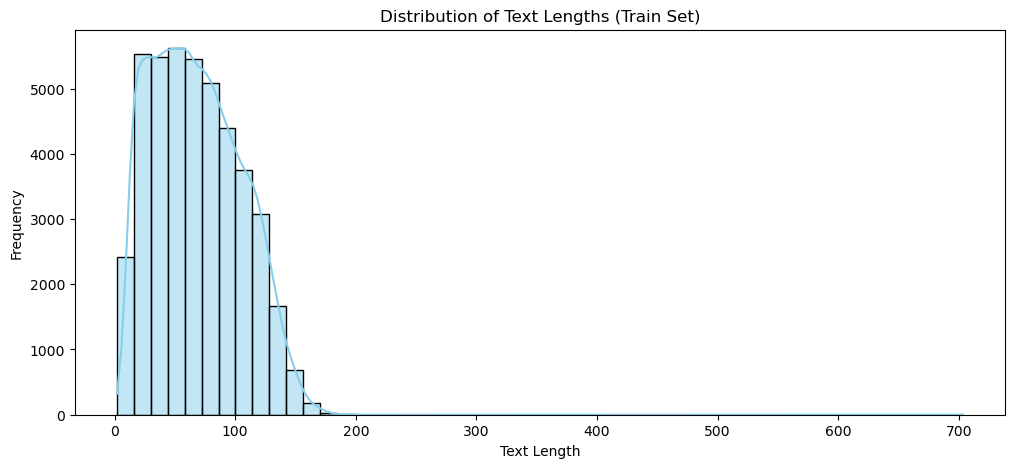

In [7]:
# Exploratory Data Analysis
plt.figure(figsize=(12, 5))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Text Lengths (Train Set)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

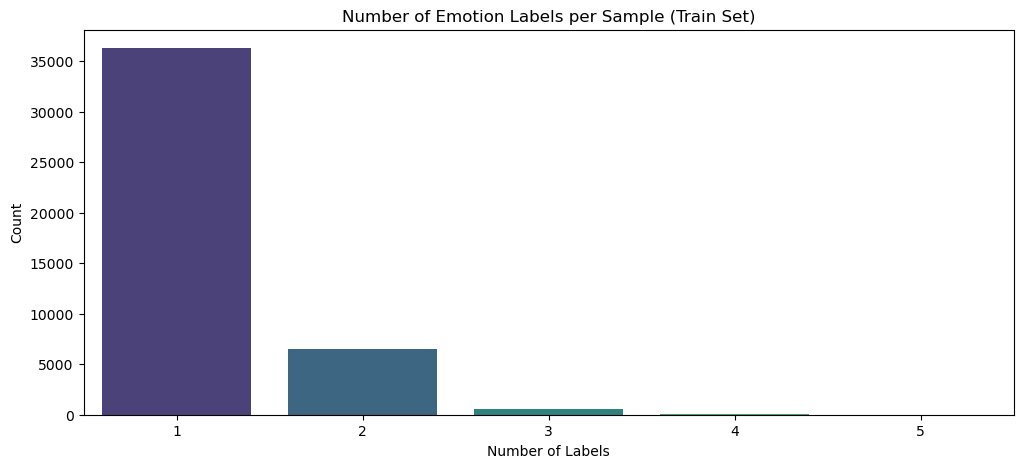

In [8]:
train_df['num_labels'] = train_df['labels'].apply(len)
plt.figure(figsize=(12, 5))
sns.countplot(x='num_labels', data=train_df, palette='viridis')
plt.title("Number of Emotion Labels per Sample (Train Set)")
plt.xlabel("Number of Labels")
plt.ylabel("Count")
plt.show()




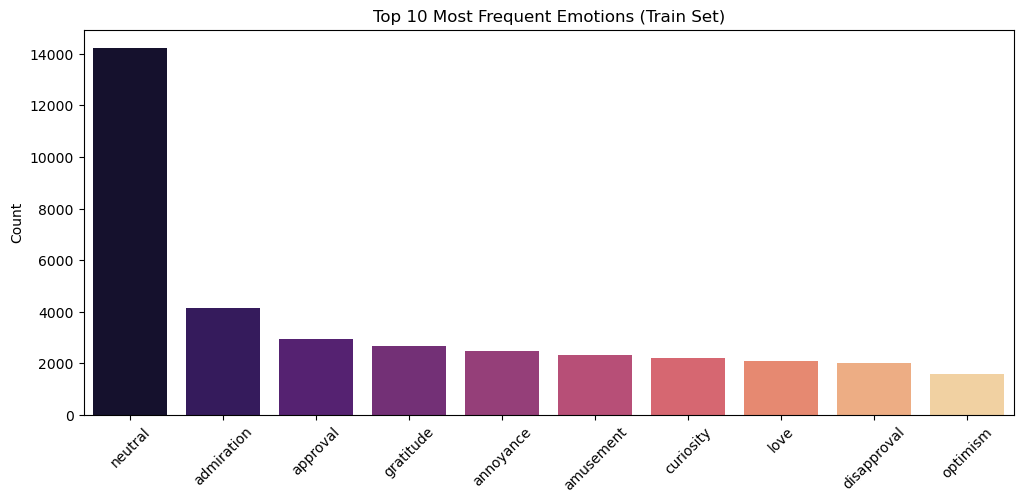

In [9]:
all_train_labels = [emotion_labels[label] for sublist in train_df['labels'] for label in sublist]
top_emotions = Counter(all_train_labels).most_common(10)

emotions, counts = zip(*top_emotions)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(emotions), y=list(counts), palette='magma')
plt.title("Top 10 Most Frequent Emotions (Train Set)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()



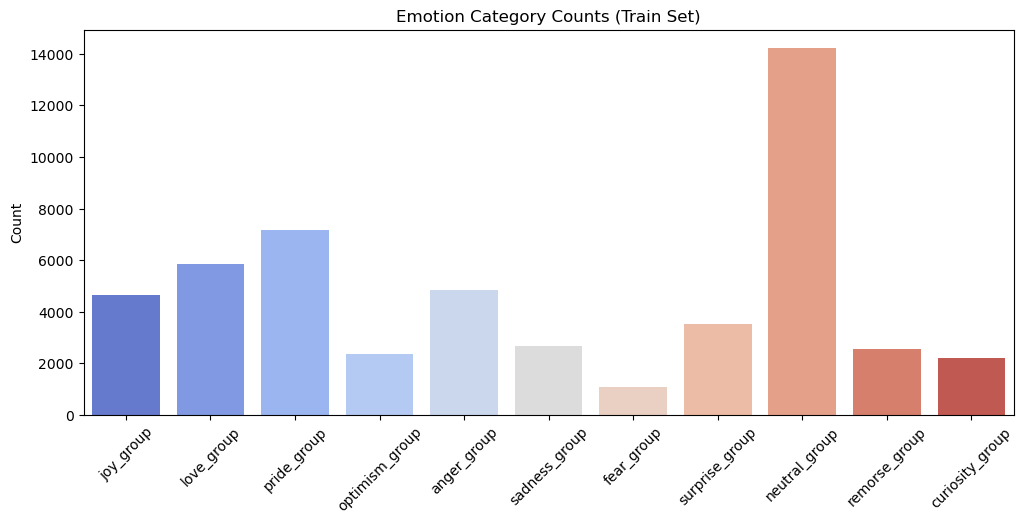

In [10]:
category_counts = {}
for cat, emo_list in emotion_categories.items():
    count = sum([1 for sublist in train_df['labels'] for label in sublist if emotion_labels[label] in emo_list])
    category_counts[cat] = count

plt.figure(figsize=(12, 5))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()), palette='coolwarm')
plt.title("Emotion Category Counts (Train Set)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()



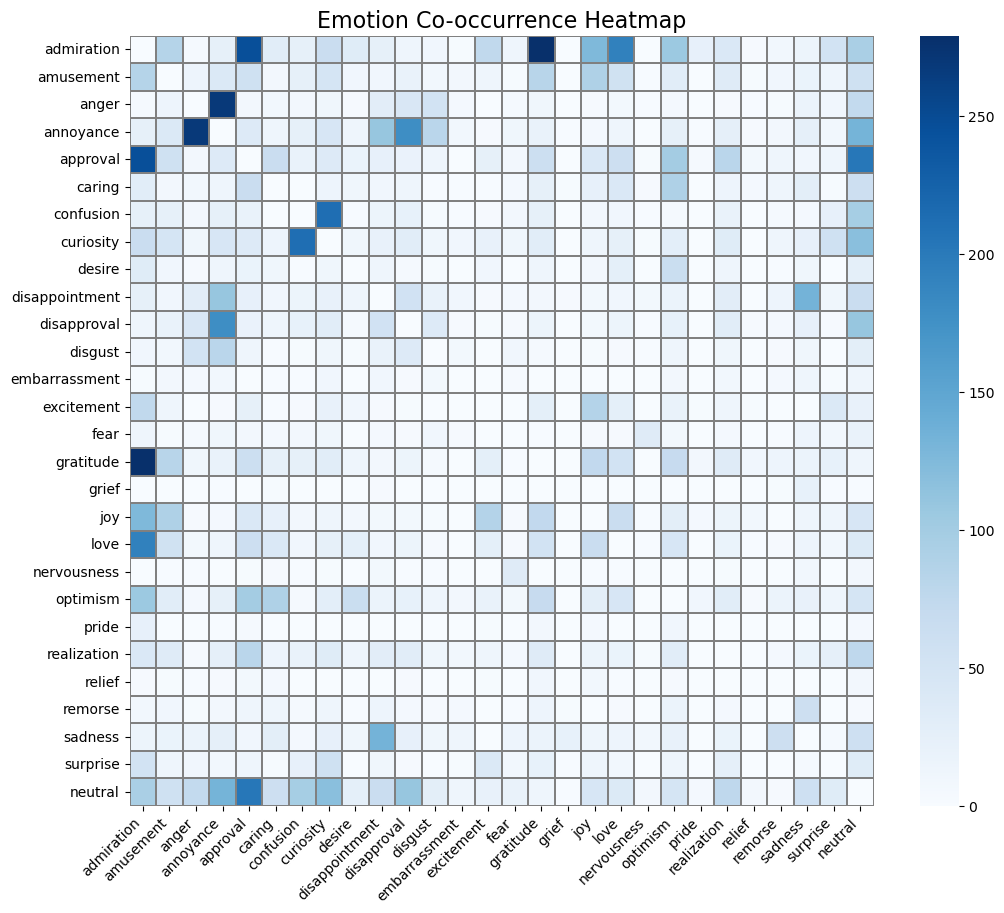

In [11]:
from itertools import combinations
import seaborn as sns

co_matrix = np.zeros((28,28), dtype=int)
for labels in train_df['labels']:
    for i,j in combinations(labels, 2):
        co_matrix[i,j] += 1
        co_matrix[j,i] += 1


plt.figure(figsize=(12,10))
sns.heatmap(co_matrix,
            xticklabels=emotion_labels,
            yticklabels=emotion_labels,
            cmap='Blues',
            cbar=True,
            linewidths=0.3,
            linecolor='gray')
plt.title("Emotion Co-occurrence Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()



In [12]:
def get_label_stats(df, name):
    all_labels = []
    for labels in df['labels']:
        all_labels.extend(labels)

    label_counts = Counter()
    for label in all_labels:
        label_counts[emotion_labels[label]] += 1

    print(f"{name}: {len(all_labels)} labels, {len(all_labels)/len(df):.2f} per sample")
    return label_counts

train_counts = get_label_stats(train_df, "Train")
val_counts = get_label_stats(val_df, "Val")
test_counts = get_label_stats(test_df, "Test")

Train: 51103 labels, 1.18 per sample
Val: 6380 labels, 1.18 per sample
Test: 6329 labels, 1.17 per sample


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

In [14]:
import os
import logging
from datetime import datetime
from typing import Dict, List, Tuple
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss, jaccard_score

In [15]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

In [16]:
class Config:
    def __init__(self):
        self.base_model = "microsoft/deberta-v3-base"
        self.num_emotions = 28  # All 28 distinct emotions
        self.max_length = 256
        self.hidden_dropout = 0.2
        self.attention_dropout = 0.1

        self.batch_size = 16
        self.learning_rate = 1e-5
        self.num_epochs = 6
        self.warmup_ratio = 0.1
        self.weight_decay = 0.01
        self.gradient_clip = 1.0
        self.threshold = 0.4

        self.focal_alpha = 0.25
        self.focal_gamma = 2.0

        self.model_save_path = "./models/goemotions"
        self.results_path = "./results/goemotions"

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_workers = 2 if torch.cuda.is_available() else 0

        os.makedirs(self.model_save_path, exist_ok=True)
        os.makedirs(self.results_path, exist_ok=True)

config = Config()
print(f"Device: {config.device}")

Device: cuda


In [17]:
class GoEmotionsDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[List[int]], tokenizer, max_length: int = 256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]).strip()

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        label_tensor = torch.zeros(28, dtype=torch.float32)
        for label in self.labels[idx]:
            label_tensor[label] = 1.0

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label_tensor
        }




In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

In [19]:
class GoEmotionsModel(nn.Module):
    def __init__(self, config: Config):
        super(GoEmotionsModel, self).__init__()
        self.config = config
        self.backbone = AutoModel.from_pretrained(config.base_model)

        hidden_size = self.backbone.config.hidden_size

        self.attention_pooling = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=config.attention_dropout,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(config.hidden_dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(config.hidden_dropout),
            nn.Linear(hidden_size // 2, config.num_emotions)
        )

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout)

        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state
        cls_output = hidden_states[:, 0, :]

        attended_output, _ = self.attention_pooling(hidden_states, hidden_states, hidden_states)
        mean_attended = attended_output.mean(dim=1)

        combined = torch.cat([cls_output, mean_attended], dim=1)
        logits = self.classifier(combined)
        return logits

In [20]:
class GoEmotionsTrainer:
    def __init__(self, config: Config):
        self.config = config
        self.logger = logging.getLogger(__name__)

        self.tokenizer = None
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.criterion = None

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_f1_macro': [],
            'val_f1_micro': []
        }

    def load_data(self) -> Tuple[Dataset, Dataset, Dataset]:
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.base_model)

        train_texts = [example['text'] for example in go_emotions['train']]
        train_labels = [example['labels'] for example in go_emotions['train']]

        val_texts = [example['text'] for example in go_emotions['validation']]
        val_labels = [example['labels'] for example in go_emotions['validation']]

        test_texts = [example['text'] for example in go_emotions['test']]
        test_labels = [example['labels'] for example in go_emotions['test']]

        train_dataset = GoEmotionsDataset(train_texts, train_labels, self.tokenizer, self.config.max_length)
        val_dataset = GoEmotionsDataset(val_texts, val_labels, self.tokenizer, self.config.max_length)
        test_dataset = GoEmotionsDataset(test_texts, test_labels, self.tokenizer, self.config.max_length)

        return train_dataset, val_dataset, test_dataset

    def setup_model(self):
        self.model = GoEmotionsModel(self.config).to(self.config.device)

        self.optimizer = AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            eps=1e-8
        )

        self.criterion = FocalLoss(
            alpha=self.config.focal_alpha,
            gamma=self.config.focal_gamma
        )

    def create_scheduler(self, train_dataloader):
        total_steps = len(train_dataloader) * self.config.num_epochs
        warmup_steps = int(total_steps * self.config.warmup_ratio)

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    def train_epoch(self, train_dataloader) -> float:
        self.model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc="Training", leave=False):
            input_ids = batch['input_ids'].to(self.config.device)
            attention_mask = batch['attention_mask'].to(self.config.device)
            labels = batch['labels'].to(self.config.device)

            self.optimizer.zero_grad()

            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()

        return total_loss / len(train_dataloader)

    def evaluate(self, val_dataloader) -> Dict[str, float]:
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Evaluating", leave=False):
                input_ids = batch['input_ids'].to(self.config.device)
                attention_mask = batch['attention_mask'].to(self.config.device)
                labels = batch['labels'].to(self.config.device)

                logits = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()

                probabilities = torch.sigmoid(logits)
                predictions = (probabilities > self.config.threshold).float()

                all_predictions.append(predictions.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)

        accuracy = accuracy_score(all_labels, all_predictions)
        hamming = hamming_loss(all_labels, all_predictions)
        jaccard = jaccard_score(all_labels, all_predictions, average='samples', zero_division=0)

        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='macro', zero_division=0
        )
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='micro', zero_division=0
        )

        return {
            'accuracy': accuracy,
            'hamming_loss': hamming,
            'jaccard_score': jaccard,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_micro': precision_micro,
            'recall_micro': recall_micro,
            'f1_micro': f1_micro,
            'loss': total_loss / len(val_dataloader)
        }

    def train(self, train_dataset: Dataset, val_dataset: Dataset):
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.num_workers,
            pin_memory=True
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers,
            pin_memory=True
        )

        self.setup_model()
        self.create_scheduler(train_dataloader)

        best_f1 = 0.0
        patience = 3
        no_improve = 0

        for epoch in range(self.config.num_epochs):
            print(f"Epoch {epoch+1}/{self.config.num_epochs}")

            train_loss = self.train_epoch(train_dataloader)
            val_metrics = self.evaluate(val_dataloader)

            print(f"Loss: {train_loss:.5f} | Val F1: {val_metrics['f1_macro']:.5f} | Acc: {val_metrics['accuracy']:.5f}")

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['val_accuracy'].append(val_metrics['accuracy'])
            self.history['val_f1_macro'].append(val_metrics['f1_macro'])
            self.history['val_f1_micro'].append(val_metrics['f1_micro'])

            if val_metrics['f1_macro'] > best_f1:
                best_f1 = val_metrics['f1_macro']
                no_improve = 0
                self.save_model('best_model.pt')
                print(f"New best F1: {best_f1:.5f}")
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        self.save_model('final_model.pt')

    def save_model(self, filename: str):
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'config': self.config.__dict__,
            'emotion_labels': emotion_labels
        }
        filepath = os.path.join(self.config.model_save_path, filename)
        torch.save(checkpoint, filepath)
        self.tokenizer.save_pretrained(self.config.model_save_path)

    def test(self, test_dataset: Dataset) -> Dict[str, float]:
        test_dataloader = DataLoader(
            test_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers
        )

        metrics = self.evaluate(test_dataloader)

        print("\nTest Results:")
        print(f"Accuracy: {metrics['accuracy']:.5f}")
        print(f"F1 Macro: {metrics['f1_macro']:.5f}")
        print(f"F1 Micro: {metrics['f1_micro']:.5f}")
        print(f"Precision Macro: {metrics['precision_macro']:.5f}")
        print(f"Recall Macro: {metrics['recall_macro']:.5f}")
        print(f"Precision Micro: {metrics['precision_micro']:.5f}")
        print(f"Recall Micro: {metrics['recall_micro']:.5f}")
        print(f"Jaccard Score: {metrics['jaccard_score']:.5f}")
        print(f"Hamming Loss: {metrics['hamming_loss']:.5f}")

        return metrics

    def predict(self, texts: List[str]) -> List[Dict[str, float]]:
        self.model.eval()
        results = []

        with torch.no_grad():
            for text in texts:
                encoding = self.tokenizer(
                    text,
                    truncation=True,
                    padding='max_length',
                    max_length=self.config.max_length,
                    return_tensors='pt'
                ).to(self.config.device)

                logits = self.model(encoding['input_ids'], encoding['attention_mask'])
                probabilities = torch.sigmoid(logits).cpu().numpy()[0]
                predictions = {emotion_labels[i]: float(prob) for i, prob in enumerate(probabilities)}
                results.append(predictions)

        return results


In [21]:
trainer = GoEmotionsTrainer(config)
train_dataset, val_dataset, test_dataset = trainer.load_data()

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 43410, Val: 5426, Test: 5427


In [22]:
trainer.train(train_dataset, val_dataset)


2025-09-04 12:37:23.838135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756989443.850234    1332 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756989443.854051    1332 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-04 12:37:23.869792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/6


Loss: 0.01567 | Val F1: 0.18765 | Acc: 0.39182
New best F1: 0.18765
Epoch 2/6


Loss: 0.00779 | Val F1: 0.42606 | Acc: 0.40711
New best F1: 0.42606
Epoch 3/6


Loss: 0.00667 | Val F1: 0.47313 | Acc: 0.40527
New best F1: 0.47313
Epoch 4/6


Loss: 0.00611 | Val F1: 0.50006 | Acc: 0.40822
New best F1: 0.50006
Epoch 5/6


Loss: 0.00571 | Val F1: 0.50694 | Acc: 0.40711
New best F1: 0.50694
Epoch 6/6


Loss: 0.00549 | Val F1: 0.50466 | Acc: 0.40546


In [23]:
test_metrics = trainer.test(test_dataset)



Test Results:
Accuracy: 0.39414
F1 Macro: 0.51238
F1 Micro: 0.60498
Precision Macro: 0.51535
Recall Macro: 0.56940
Precision Micro: 0.54144
Recall Micro: 0.68542
Jaccard Score: 0.56324
Hamming Loss: 0.03728


In [24]:
sample_texts = [
    "I love this so much!",
    "This makes me really angry",
    "I'm feeling sad about this",
    "I'm excited and grateful!",
    "This is confusing",
    "I'm worried about tomorrow",
    "That was hilarious",
    "I feel proud of myself"
]

In [26]:
print("Sample Predictions:")

predictions = trainer.predict(sample_texts)

for text, pred in zip(sample_texts, predictions):
    top_emotions = sorted(pred.items(), key=lambda x: x[1], reverse=True)
    relevant = [(emotion, score) for emotion, score in top_emotions if score > 0.2][:3]
    
    print(f"\n'{text}'")
    for emotion, score in relevant:
        print(f"  {emotion}: {score:.3f}")

Sample Predictions:

'I love this so much!'
  love: 0.869
  admiration: 0.208

'This makes me really angry'
  anger: 0.714
  annoyance: 0.335

'I'm feeling sad about this'
  sadness: 0.804
  disappointment: 0.280
  grief: 0.243

'I'm excited and grateful!'
  excitement: 0.637
  gratitude: 0.477
  joy: 0.409

'This is confusing'
  confusion: 0.787
  neutral: 0.206

'I'm worried about tomorrow'
  fear: 0.646
  nervousness: 0.605
  sadness: 0.331

'That was hilarious'
  amusement: 0.837
  joy: 0.318

'I feel proud of myself'
  pride: 0.512
  admiration: 0.428
  neutral: 0.256


In [28]:
results = {
    'test_metrics': test_metrics,
    'config': config.__dict__,
    'training_completed': datetime.now().isoformat()
}

with open(os.path.join(config.results_path, 'results.json'), 'w') as f:
    json.dump(results, f, indent=2, default=str)

In [29]:
print("Training completed successfully!")

Training completed successfully!
